# Computing ephemerides of Solar System Objects

The purpose of this nootbok is to practice at querying API (Application Public Interface) of Solar System services.

We will use the generation of ephemerides as example, with two different services:
- [**Miriade**](https://ssp.imcce.fr/webservices/miriade) of the [IMCCE](https://www.imcce.fr/), directly from the API
- [**Ephemeris Service**](https://www.minorplanetcenter.net/iau/MPEph/MPEph.html) of the [Minor Planet Center](https://minorplanetcenter.net/), through an [`astroquery`](https://astroquery.readthedocs.io/en/latest/) wrapper

Other similar services exist and can be queried programmatically:
- [**Horizons**](https://ssd.jpl.nasa.gov/horizons/) from [JPL SSD](https://ssd.jpl.nasa.gov/): from their [API](https://ssd-api.jpl.nasa.gov/doc/horizons.html) or with an [`astroquery`](https://astroquery.readthedocs.io/en/latest/) [wrapper](https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html)
- [**Miriade**](https://ssp.imcce.fr/webservices/miriade) from the [IMCCE](https://www.imcce.fr/), using the [`astroquery`](https://astroquery.readthedocs.io/en/latest/) [wrapper](https://astroquery.readthedocs.io/en/latest/imcce/imcce.html#miriade-ephemeris-service) this time


In [1]:
import os
import io
import requests
import json
from astropy.coordinates import Angle

import rocks
import pandas as pd
import time as t

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.projections

from astropy.coordinates import SkyCoord

from astroquery.mpc import MPC

## Define the parameters of the query

We define here the targets we want to observe, when, for how many epochs, separated by a time step, *etc*

In [2]:
# When we observe
epoch = "2024-01-01T00:00:00"
nbd = 180
step = "5d"

# What we observe
targets = ["Pallas", 3, "vesta", "2003 EL61"]

# Where are we observing from
observer = "309"  # Paranal, see https://www.minorplanetcenter.net/iau/lists/ObsCodesF.html

## 1. Direct API query on IMCCE/Miriade

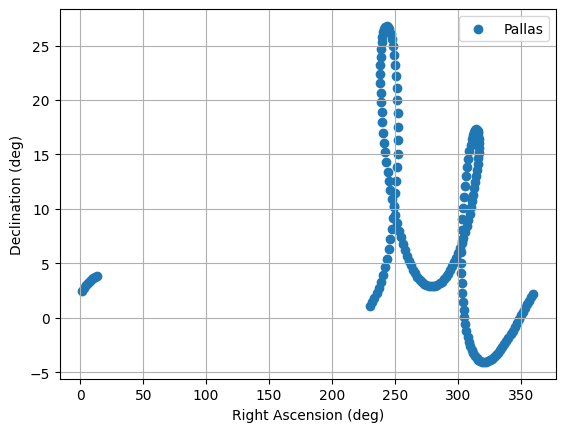

In [3]:
# Service URL
url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?"


# Query parameters
# The request package that we will use will create the full URL for us from the dictionary below
params = {
    "-name": targets[0],
    "-ep": epoch, 
    "-nbd": nbd,
    "-step": step,
    "-mime": "json",
    "-observer": observer,
    "-tscale": "UTC",
    "-from": "Student_at_Les_Houches",
}

# Update the target of the query with its latest designation
# It is a safety step, to avoid issues 
ids = rocks.id(targets[0])
params["-name"] = ids[0]

# Query the service
try:
    r = requests.post(url, params=params, timeout=2000)
except requests.exceptions.ReadTimeout:
    print("Request timed out")

# Convert the json results into a python dictionary
result = json.loads(r.content)

# Get ephemerides in a pandas DataFrame
eph = pd.DataFrame.from_dict(result["data"])

# Convert RA/Dec from hours/degrees to degrees
coords = SkyCoord(eph["RA"], eph["DEC"], unit=("hour", "deg"))
eph["RA_deg"] = coords.ra.degree
eph["DEC_deg"] = coords.dec.degree

# Plot the trajectory
fig, ax = plt.subplots()
ax.scatter(eph["RA_deg"], eph["DEC_deg"], label=targets[0])
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.grid()
ax.legend()

The result of the query contains several items, including information on the SSO, the signification of each columns, the unit, the reference frame, *etc*, see the different keys of the dictionary:

In [4]:
result.keys()

dict_keys(['sso', 'coosys', 'ephemeris', 'data', 'datacol', 'unit'])

In [5]:
result["sso"]

{'num': 2,
 'name': 'Pallas',
 'type': 'asteroid',
 'parameters': {'source': 'ASTORB',
  'author': 'L.H. Wasserman',
  'physical_model': '',
  'diameter': 498.1,
  'number_observations': 8492,
  'orbital_arc': 73790,
  'ceu': 0.013,
  'ceu_rate': 3.8e-05,
  'orbital_period': 1684.2339929220464,
  'mass': 0.0,
  'dynamical_class': 'MB>Middle',
  'taxonomy': {'class': 'B', 'param': 'a', 'source': 'DeMeo et al. (2009)'}}}

In [6]:
result["unit"]

{'diameter': 'km',
 'orbital_arc': 'days',
 'ceu': 'arsec',
 'ceu_rate': 'arcsec/day',
 'orbital_period': 'day',
 'mass': 'kg',
 'topocenter': {'longitude': 'deg', 'latitude': 'deg', 'altitude': 'm'},
 'RA': 'h',
 'DEC': 'deg',
 'Dobs': 'au',
 'VMag': 'mag',
 'Phase': 'deg',
 'Elong.': 'deg',
 'dRAcosDEC': 'arcsec/min',
 'dDEC': 'arcsec/min',
 'RV': 'km/s'}

etc.

We can easily script this for several targets

Request of ephemerides for Pallas took 0.9 seconds
Request of ephemerides for Juno took 1.2 seconds
Request of ephemerides for Vesta took 0.9 seconds


Request of ephemerides for Haumea took 1.9 seconds


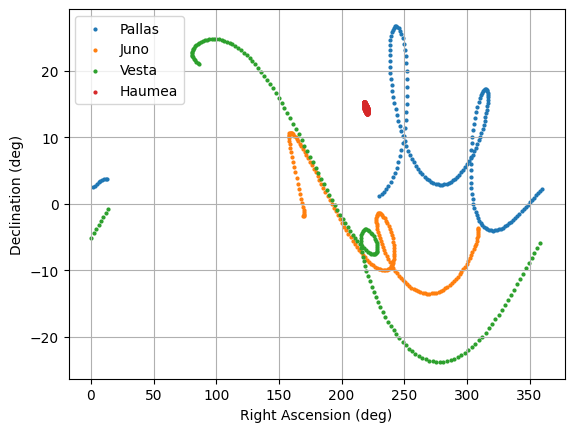

In [9]:
fig, ax = plt.subplots()

for i, sso in enumerate(targets):
    # Update the target of the query, but check first its designation
    ids = rocks.id(sso)
    params["-name"] = ids[0]

    # Query the service
    t0 = t.time()
    try:
        r = requests.post(url, params=params, timeout=2000)
    except requests.exceptions.ReadTimeout:
        print("Request timed out")
    t1 = t.time()
    print(f"Request of ephemerides for {ids[0]} took {t1-t0:.1f} seconds")

    # Convert the json results into a python dictionary
    result = json.loads(r.content)

    # Get ephemerides in a pandas DataFrame
    eph = pd.DataFrame.from_dict(result["data"])

    # Convert RA/Dec from hours/degrees to degrees
    coords = SkyCoord(eph["RA"], eph["DEC"], unit=("hour", "deg"))
    eph["RA_deg"] = coords.ra.degree
    eph["DEC_deg"] = coords.dec.degree

    # Plot the trajectory
    ax.scatter(eph["RA_deg"], eph["DEC_deg"], s=4, label=params["-name"])

# Set up axes
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.grid()
ax.legend()

Whenever you want to use an API, have a quick look at the documentation to see what it can do and how to use it!
In the present case of Miriade, the documentation is available at https://ssp.imcce.fr/webservices/miriade/api/ephemcc/

For instance, you can easily switch to **ecliptic** coordinates (*rplane* keyword), change the list of reported columns ([*tcoor* keyword](https://ssp.imcce.fr/webservices/miriade/api/ephemcc/#output-results)), compute magnitude in different filters ([*colors* keyword](https://ssp.imcce.fr/webservices/miriade/howto/ephemcc/#howto-filters)), even in the thermal infrared
([*thermalFlux* keyword](https://ssp.imcce.fr/webservices/miriade/howto/ephemcc/#howto-thermalflux)).

## 2. Using astroquery wrapper to query MPC

In the example above, we used the `requests` module to directly interact with the API. We are in full control of what we query.

In some cases, someone already developped a python interface to the service, as illustrated below, thanks to [`astroquery`](https://astroquery.readthedocs.io/en/latest/). 

Depending on his/her needs, available time, coding capacities, *etc*, one may choose either of these two approaches.

In [10]:
# Update the target of the query, but check first its designation
ids = rocks.id(targets[0])

t0 = t.time()
try:
    eph = MPC.get_ephemeris(
        ids[0], step=step, start=epoch, number=nbd, location=observer
    )
except requests.exceptions.ReadTimeout:
    print("Request timed out")
t1 = t.time()
print(f"Request of ephemerides for {ids[0]} took {t1-t0:.1f} seconds")

Request of ephemerides for Pallas took 0.1 seconds


The result here is an [`astropy`](https://www.astropy.org/) [Table](https://docs.astropy.org/en/stable/table/) object. It is in essence a matrix, that can be accessed by rows/columns. Each column is a [`Quantity`](https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity): it has a unit.

In [11]:
# Show first four rows
eph[:4]

Date,RA,Dec,Delta,r,Elongation,Phase,V,Proper motion,Direction,Azimuth,Altitude,Sun altitude,Moon phase,Moon distance,Moon altitude,Uncertainty 3sig,Unc. P.A.
,deg,deg,AU,AU,deg,deg,mag,arcsec / h,deg,deg,deg,deg,,deg,deg,arcsec,deg
Time,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,int64,int64,float64,float64
2024-01-01 00:00:00.000,230.0008333333333,1.1197222222222223,3.067,2.626,54.8,17.8,9.6,60.09,81.9,223,-60,-6,0.78,71,-40,0.0,81.6
2024-01-06 00:00:00.000,231.9408333333333,1.4322222222222223,3.026,2.639,57.9,18.4,9.6,59.05,79.9,219,-62,-6,0.32,25,-51,0.0,90.0
2024-01-11 00:00:00.000,233.83208333333332,1.8080555555555555,2.983,2.651,61.1,19.0,9.6,57.92,77.8,213,-63,-6,0.0,57,-9,0.0,81.0
2024-01-16 00:00:00.000,235.6695833333333,2.2483333333333335,2.938,2.663,64.3,19.4,9.6,56.71,75.5,208,-65,-6,0.26,122,40,0.0,80.7


An advantage of using a community-supported wrapper is that you do not have to figure out how to build the query nor how to decode the answer.

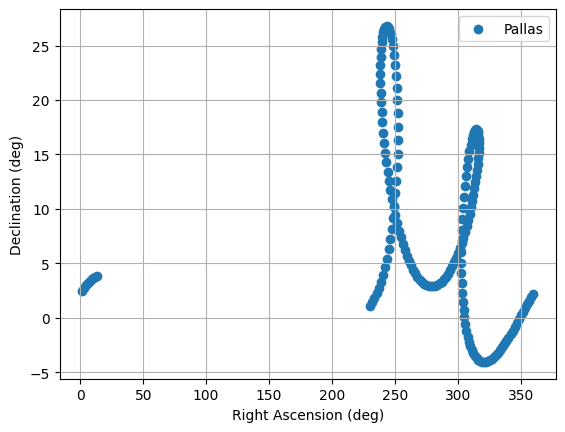

In [12]:
# Plot the trajectory
fig, ax = plt.subplots()
ax.scatter(eph["RA"], eph["Dec"], label=ids[0])
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.grid()
ax.legend()

## Exercices

### Ex1. Plan your night of observations 

Let's start with a simple exercice, simply changing some parameters. Get the ephemerides for
- KBO Haumea
- On the night of 2024, February the 10th
- From La Silla observatory
- With local coordinates (azimuth and elevation)
- With a time step between points of 5 minutes
- (optional) Plot the elevation of the target as function of time

In [13]:
# Code here

### Ex2. Cartesian coodinates

You are interested in the geometry of encounter between your favorite space mission (e.g. [Lucy](https://science.nasa.gov/mission/lucy/)) and a flyby target (e.g., [Patroclus](https://ssp.imcce.fr/forms/ssocard/Patroclus)). In such case, you would need the position of the target in heliocentric cartesian coordinates.

- Compute the trajectory of asteroids Patroclus from 2020 to 2030 in heliocentric ecliptic cartesian coordinates using Miriade.
- Plot its trajectory in a ecliptic (x,y) plane.
- (optional) Overplot the motion of planets Earth and Jupiter over the same time period

In [14]:
# Code here!


<br><br><br><br><br><br><br><br>
Solutions comes here below
<br><br><br><br><br>
Don't look at the solutions without trying yourself!
<br><br><br><br>

<br><br><br><br>
Ready?

<br><br><br><br>
Not cheating?


### Solution Ex1. Plan your night of observations 

Let's start with a simple exercice, simply changing some parameters. Get the ephemerides for
- KBO Haumea
- On the night of 2024, February the 10th
- From La Silla observatory
- With local coordinates (azimuth and elevation)
- With a time step between points of 5 minutes
- (optional) Plot the elevation of the target as function of time

The same with the planets!

In [15]:
# Service URL
url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?"


# Query parameters
params = {
    "-name": "Haumea",
    "-ep": "2024-02-10",
    "-nbd": (60 / 5) * 24,
    "-step": "5min",
    "-mime": "json",
    "-observer": "809",
    "-tcoor": 5,
    "-tscale": "UTC",
    "-output": "--jd",
    "-from": "Student_at_Les_Houches",
}

# Query the service
try:
    r = requests.post(url, params=params, timeout=2000)
except requests.exceptions.ReadTimeout:
    print("Request timed out")

# Convert the json results into a python dictionary
result = json.loads(r.content)

# Get ephemerides in a pandas DataFrame
eph = pd.DataFrame.from_dict(result["data"])

Text(0.5, 0, 'Azimuth (deg)')

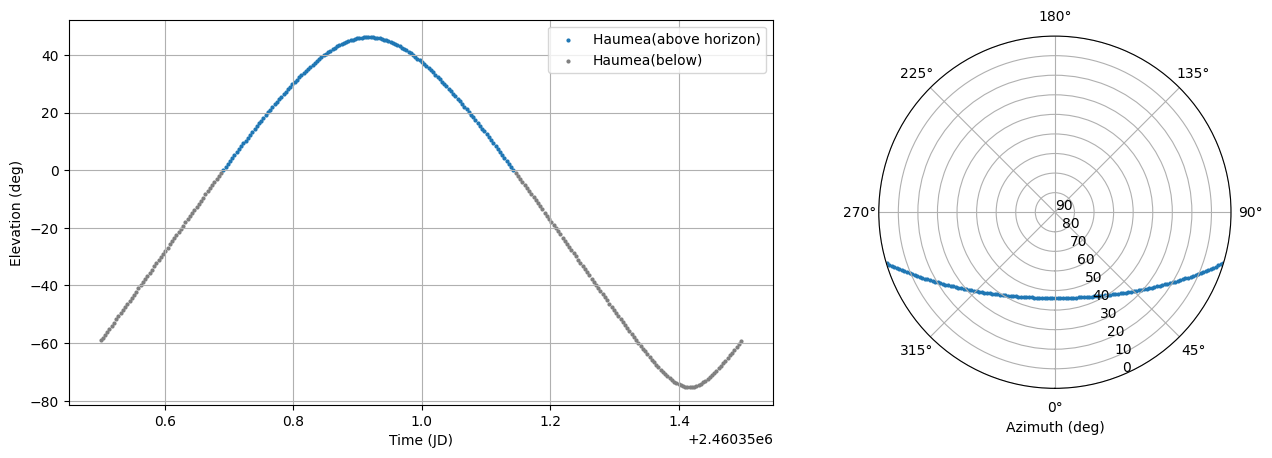

In [16]:
# Plot elevation curves
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]})

# Object is above the horizon
cond = eph["H"] > 0

# Plot the elevation as function of time
ax[0].scatter(eph.loc[cond, "Date"], eph.loc[cond, "H"], label=params["-name"]+ "(above horizon)", s=4)
ax[0].scatter(eph.loc[~cond, "Date"], eph.loc[~cond, "H"], label=params["-name"] +"(below)",color="grey", s=4)

# Plot the path on the sky
ax[1].remove()
ax[1] = fig.add_subplot(1, 2, 2, projection="polar")
ax[1].scatter(
    np.radians(eph.loc[cond, "Az"]), eph.loc[cond, "H"], label=params["-name"], s=4
)
ax[1].set_ylim(90, 0)
ax[1].set_theta_zero_location("S")

# Set up axes
ax[0].set_xlabel("Time (JD)")
ax[0].set_ylabel("Elevation (deg)")
ax[0].grid()
ax[0].legend()
ax[1].set_xlabel("Azimuth (deg)")


### Ex2. Cartesian coodinates

You are interested in the geometry of encounter between your favorite space mission (e.g. [Lucy](https://science.nasa.gov/mission/lucy/)) and a flyby target (e.g., [Patroclus](https://ssp.imcce.fr/forms/ssocard/Patroclus)). In such case, you would need the position of the target in heliocentric cartesian coordinates.

- Compute the trajectory of asteroids Patroclus from 2020 to 2030 in heliocentric ecliptic cartesian coordinates using Miriade.
- Plot its trajectory in a ecliptic (x,y) plane.
- (optional) Overplot the motion of planets Earth and Jupiter over the same time period

Whenever you want to use an API, have a quick look at the documentation to see what it can do and how to use it!
In the present case of Miriade, the documentation is available at https://ssp.imcce.fr/webservices/miriade/api/ephemcc/

For instance, you can easily switch to **ecliptic** coordinates (*rplane* keyword), change the list of reported columns ([*tcoor* keyword](https://ssp.imcce.fr/webservices/miriade/api/ephemcc/#output-results)), compute magnitude in different filters ([*colors* keyword](https://ssp.imcce.fr/webservices/miriade/howto/ephemcc/#howto-filters)), even in the thermal infrared
([*thermalFlux* keyword](https://ssp.imcce.fr/webservices/miriade/howto/ephemcc/#howto-thermalflux)).

In [17]:
# Service URL
url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?"


# Query parameters
params = {
    "-name": "Patroclus",
    "-ep": "2020-01-01",
    "-nbd": 360,
    "-step": "10d",
    "-mime": "json",
    "-observer": "@sun",
    "-rplane": 2,
    "-tcoor": 2,
    "-output": "--jd",
    "-from": "Student_at_Les_Houches",
}

# Query the service
try:
    r = requests.post(url, params=params, timeout=2000)
except requests.exceptions.ReadTimeout:
    print("Request timed out")

# Convert the json results into a python dictionary
result = json.loads(r.content)

# Get ephemerides in a pandas DataFrame
eph = pd.DataFrame.from_dict(result["data"])

(-7.0, 7.0)

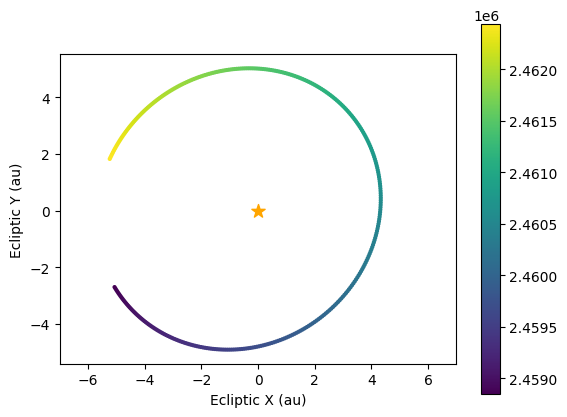

In [18]:
# Plot elevation curves
fig, ax = plt.subplots()

# The Sun!
ax.scatter( 0,0, marker='*', s=100, color='orange', label="Sun")

# Plot the trajectory
im = ax.scatter(eph["px"], eph["py"], 
           c=eph['Date'], label=params["-name"], s=4)

cbar = fig.colorbar(im)

# Set up axes
ax.set_xlabel("Ecliptic X (au)")
ax.set_ylabel("Ecliptic Y (au)")
ax.set_aspect("equal")
ax.set_xlim(-7, 7)

The same with the planets!

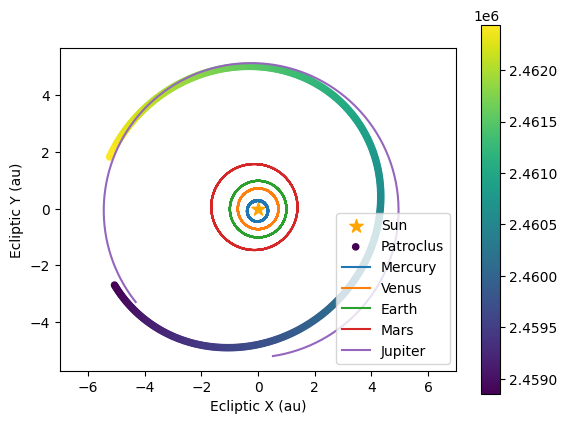

In [19]:
# Plot elevation curves
fig, ax = plt.subplots()


# The Sun!
ax.scatter( 0,0, marker='*', s=100, color='orange', label="Sun")

# Plot the trajectory
im = ax.scatter(eph["px"], eph["py"], 
           c=eph['Date'], label=params["-name"], s=20)
cbar = fig.colorbar(im)

# Add planets
for i,p in enumerate(['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter']):
    
    # Query parameters
    params = {
        "-name": f"p:{p}",
        "-ep": "2020-01-01",
        "-nbd": 360,
        "-step": "10d",
        "-mime": "json",
        "-observer": "@sun",
        "-rplane": 2,
        "-tcoor": 2,
        "-output": "--jd",
        "-from": "Student_at_Les_Houches",
    }


    # Query the service *if* the ephemerides is not already downloaded
    if not os.path.exists( f"{p}.csv"):
        try:
            r = requests.post(url, params=params, timeout=2000)
        except requests.exceptions.ReadTimeout:
            print("Request timed out")

        # Convert the json results into a python dictionary
        result = json.loads(r.content)

        # Get ephemerides in a pandas DataFrame
        planet = pd.DataFrame.from_dict(result["data"])
        planet.to_csv(f"{p}.csv", index=False)
    
    else: 
        planet = pd.read_csv(f"{p}.csv")

    # Overplot the planet
    ax.plot(planet["px"], planet["py"], label=p)

# Set up axes
ax.set_xlabel("Ecliptic X (au)")
ax.set_ylabel("Ecliptic Y (au)")
ax.set_aspect("equal")
ax.set_xlim(-7, 7)
ax.legend(loc='lower right')